# ファイルの扱い
## Reader
TensorflowではReaderというクラスが定義されている。  
このクラスは、Queueからファイル名を一つ取ってきて、そのファイルの中身を読み出す機能を提供。  
string_input_producerなど、Queueを生成する関数とともに利用する。

### 使用例: 

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf

FILES = map(lambda e: "train_%d.jpg" % (e), [40, 67, 70])

q = tf.train.string_input_producer(FILES, shuffle=False)
reader = tf.WholeFileReader()
key, value = reader.read(q)
image = tf.image.decode_jpeg(value, channels=3)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(3):
        k, r = sess.run([key, image])
        print("name = %s, height = %d, width = %d" % (k, r.shape[0], r.shape[1]))
    
    coord.request_stop()
    coord.join(threads)



name = train_40.jpg, height = 861, width = 1000
name = train_67.jpg, height = 1000, width = 750
name = train_70.jpg, height = 640, width = 423


## Readerの種類
https://www.tensorflow.org/api_docs/python/io_ops/readers を参考
###  tf.TextLineReader
テキストファイルを読み込んで、その値を1行ずつ出力する。

In [2]:
CSV_FILES = ["test1.csv", "test2.csv"]

q = tf.train.string_input_producer(CSV_FILES, shuffle=False)
reader = tf.TextLineReader()
key, value = reader.read(q)

record_defaults = [["a"],[1],[1],[1]]
cols = tf.decode_csv(value, record_defaults=record_defaults)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(15):
        k, r = sess.run([key, cols])
        print(k, r)
    coord.request_stop()
    coord.join(threads)

test1.csv:1 ['a', 1, 3, 5]
test1.csv:2 ['b', 2, 4, 6]
test1.csv:3 ['c', 3, 6, 9]
test1.csv:4 ['d', 4, 8, 12]
test1.csv:5 ['e', 5, 10, 15]
test2.csv:1 ['f', 1, 3, 5]
test2.csv:2 ['g', 2, 4, 6]
test2.csv:3 ['h', 3, 6, 9]
test2.csv:4 ['k', 4, 8, 12]
test2.csv:5 ['i', 5, 10, 15]
test1.csv:1 ['a', 1, 3, 5]
test1.csv:2 ['b', 2, 4, 6]
test1.csv:3 ['c', 3, 6, 9]
test1.csv:4 ['d', 4, 8, 12]
test1.csv:5 ['e', 5, 10, 15]


### tf.WholeFileReader
ファイルをすべて読み込む(サンプルは↑にあるので略)

### tf.IdentityReader
key, valが同じ値になるReader(実質Queueから値を読み出すだけ)

In [3]:
reader = tf.IdentityReader()
key, value = reader.read(q)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(3):
        k, v = sess.run([key,  value])
        print(k, v)
        
    coord.request_stop()
    coord.join(threads)

test1.csv test1.csv
test2.csv test2.csv
test1.csv test1.csv


### tf.TFRecoadReader
Tensorflow用にオブジェクトをシリアライズしたものを格納するファイル形式のリーダ

### Writer
name = train_40.jpg, height = 861, width = 1000
name = train_67.jpg, height = 1000, width = 750
name = train_70.jpg, height = 640, width = 423
### Reader
name = train_40.jpg, height = 861, width = 1000
name = train_67.jpg, height = 1000, width = 750
name = train_70.jpg, height = 640, width = 423


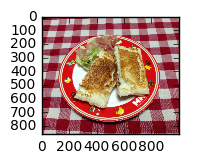

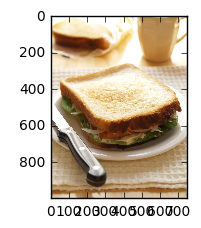

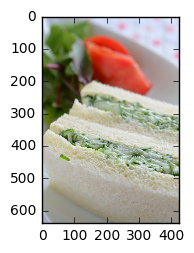

In [14]:
import pickle # 画像データシリアライズに良さそうなんで利用
from PIL import Image # 画像表示用
import matplotlib.pyplot as plt # 画像表示用

# int64 feature生成ヘルパー関数
def _int64_feature(value):
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

# bytes feature生成ヘルパー関数
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 読み込んだ画像データの各種要素からExampleを生成する。
# Exampleモジュールはシリアライズ・デシリアライズが簡単にできるため
# ファイルに吐き出すのが用意
def convert_to_example(filename, image_buffer, height, width):
    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': _int64_feature(height),
        'image/width' : _int64_feature(width),
        'image/encoded': _bytes_feature(tf.compat.as_bytes(pickle.dumps(image_buffer))),
        'image/filename': _bytes_feature(tf.compat.as_bytes(os.path.basename(filename)))
    }))
    return example

# ↑のデコード用のマッピング、詳細はまだ勉強中
feature_map = {
    'image/height' : tf.FixedLenFeature([], tf.int64),
    'image/width'  : tf.FixedLenFeature([], tf.int64),
    'image/encoded': tf.FixedLenFeature([], tf.string),
    'image/filename': tf.FixedLenFeature([], tf.string)
}

# ファイルの生成を先に行う
# 特殊なファイル形式なので生成方法も記載
writer = tf.python_io.TFRecordWriter("tfrecord") # ファイルWriteを指定

# ファイルからデータを読み出して画像を生成する(↑参照)
q = tf.train.string_input_producer(FILES, shuffle=False) 
reader = tf.WholeFileReader()
key, value = reader.read(q)
image = tf.image.decode_jpeg(value, channels=3)

print("### Writer")

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(3):
        k, r = sess.run([key, image])
        height = r.shape[0]
        width = r.shape[1]
        # Example形式にしたものをシリアライズして、ファイルに書き込む
        writer.write(convert_to_example(k, r, height, width).SerializeToString())
        print("name = %s, height = %d, width = %d" % (k, r.shape[0], r.shape[1]))

    coord.request_stop()
    coord.join(threads)
    # 終了したらクローズ
    writer.close()

q = tf.train.string_input_producer(["tfrecord"], shuffle=False)
reader = tf.TFRecordReader()
key, value = reader.read(q)
features = tf.parse_single_example(value, feature_map) # この関数でデシリアライズする

print("### Reader")

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(3):
        feature = sess.run(features)
        print("name = %s, height = %d, width = %d" % (feature['image/filename'], feature['image/height'], feature['image/width']))
        plt.figure().add_subplot(1,3,i+1)
        # 画像データはpickleでシリアライズしたので、それをデシリアライズ
        plt.imshow(pickle.loads(feature['image/encoded']))
    
    plt.show()
    coord.request_stop()
    coord.join(threads)
